# TIPO DE VARIABLES

| Variable      | Descripción                         | Tipo              | Entrada/Salida |
| ------------- | ----------------------------------- | ----------------- | -------------- |
| X             | Coordenada geográfica Este          | Numérica continua | Entrada        |
| Y             | Coordenada geográfica Norte         | Numérica continua | Entrada        |
| class_hidr    | Clasificación hidrológica del suelo | Categórica        | Entrada        |
| CATEGORIA_SAL | Nivel de salinidad del suelo        | Categórica        | Salida         |

# Configuración y librerías

In [1]:
import os, sys, pickle, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix,
                            f1_score, balanced_accuracy_score)

from sklearn.base import clone
#Modelos clasicos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
#Modelos de ensamble
from sklearn.ensemble import (BaggingClassifier, AdaBoostClassifier,
                            GradientBoostingClassifier, VotingClassifier)

sys.path.append(os.path.join(os.getcwd(), 'src'))

import config
from src.modeling.cross_validation import cross_validate

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print('Python', sys.version)
print('pandas', pd.__version__)


Python 3.10.0 | packaged by conda-forge | (default, Nov 10 2021, 13:20:59) [MSC v.1916 64 bit (AMD64)]
pandas 2.3.3


In [2]:
# Funciones utilitarias (gráficos y tablas)
from typing import List

def plot_class_distribution(y, title='Distribución de la variable objetivo'):
    counts = pd.Series(y).value_counts().sort_index()
    ax = counts.plot(kind='bar', color=['#4daf4a','#377eb8','#e41a1c'])
    ax.set_title(title)
    ax.set_xlabel('Clase')
    ax.set_ylabel('Conteo')
    for i, v in enumerate(counts.values):
        ax.text(i, v+0.5, str(v), ha='center')
    plt.tight_layout(); plt.show()

def plot_confusion_matrix(cm: np.ndarray, labels: List[str], title: str):
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(cm, cmap='Blues')
    ax.set_title(title)
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Real')
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()


## Entendimiento de los Datos (EDA)
- Dataset: `salinity_curated.csv`
- Variables: `X` (num), `Y` (num), `class_hidr` (cat), `CATEGORIA_SAL` (cat, **objetivo**).
- Nulos: `class_hidr` tiene 2 nulos → se imputan como `'MISSING'`.

In [3]:
# Cargar datos
df = pd.read_csv(os.path.join(config.path['curated_data'], 'salinity_curated.csv'))
print(df.shape)
df.head()

(809, 4)


,X,Y,class_hidr,CATEGORIA_SAL
0,1299675.970,1827467.800,A4,SALINIDAD_ALTA
1,1299536.070,1826712.393,A4,SALINIDAD_MEDIA
2,1299575.238,1827158.339,A4,SALINIDAD_ALTA
3,1138103.000,1758322.000,A4,SALINIDAD_ALTA
4,1138263.000,1757806.000,A4,SALINIDAD_ALTA


In [4]:
# Resumen rápido
print('Columnas:', df.columns.tolist())
print('\nNulos por columna:\n', df.isna().sum())
print('\nTipos:\n', df.dtypes)
print('\nClases objetivo (conteos):\n', df['CATEGORIA_SAL'].value_counts())

# Descriptivos de X,Y
df[['X','Y']].describe()

Columnas: ['X', 'Y', 'class_hidr', 'CATEGORIA_SAL']

Nulos por columna:
 X                0
Y                0
class_hidr       0
CATEGORIA_SAL    0
dtype: int64

Tipos:
 X                float64
Y                float64
class_hidr        object
CATEGORIA_SAL     object
dtype: object

Clases objetivo (conteos):
 CATEGORIA_SAL
SALINIDAD_MEDIA    332
SALINIDAD_ALTA     317
SALINIDAD_BAJA     160
Name: count, dtype: int64


,X,Y
count,8.090000e+02,8.090000e+02
mean,1.160425e+06,1.750712e+06
std,3.354585e+04,3.306599e+04
min,1.058434e+06,1.654390e+06
25%,1.136399e+06,1.735212e+06
50%,1.159057e+06,1.757192e+06
75%,1.178844e+06,1.773107e+06
max,1.312308e+06,1.846697e+06


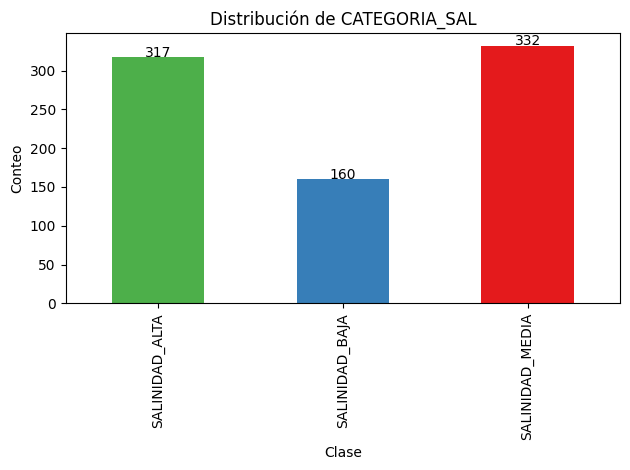

In [5]:
# Distribución de la clase
plot_class_distribution(df['CATEGORIA_SAL'], title='Distribución de CATEGORIA_SAL')

## Preparación de datos
- Los datos vienen limpios del procesamiento de datos consignado en `__main__.py`.
- Escalado (`MinMaxScaler`) de `X` y `Y`.
- Codificación (`OneHotEncoder`) de `class_hidr`.

In [6]:
#Relación hidrogeología vs sanilidad
pd.crosstab(df['class_hidr'], df['CATEGORIA_SAL'])

CATEGORIA_SAL,SALINIDAD_ALTA,SALINIDAD_BAJA,SALINIDAD_MEDIA
class_hidr,,,
A2,18,20,47
A3,42,33,66
A4,255,103,211
B2,1,0,1
B3,0,1,1
B4,1,3,4
C2,0,0,2


In [7]:
#Imputación simple para categórica
df['class_hidr'] = df['class_hidr'].fillna('MISSING')
X = df[['X','Y','class_hidr']] #features
y = df['CATEGORIA_SAL'] #target

# ColumnTransformer de preprocesamiento
preprocess = ColumnTransformer([
    ('num', MinMaxScaler(), ['X','Y']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['class_hidr']),
])

#Dimensión final 2 variables numéricas escaladas 8 variables generadas por one-hot encoding de class_hidr
preprocess = preprocess.fit(X)
le = LabelEncoder()
y_encoded = pd.Series(data=le.fit_transform(y))

## Modelamiento (Modelos clásicos + GridSearchCV)
**Métrica primaria**: `f1_macro` (trata clases por igual), **secundaria**: `balanced_accuracy`, Se toma en cuenta tambien el ROC `roc_auc_ovr_weighted`.
Se realiza **GridSearchCV** con `StratifiedKFold(n_splits=10, shuffle=True, random_state=42)` para cada modelo, buscando optimizar `f1_macro`. Se reportan también `balanced_accuracy` y `roc_auc_ovr_weighted` para cada modelo.

In [ ]:
def get_fold_metrics(gs: GridSearchCV, model: str) -> pd.DataFrame:
    results = gs.cv_results_
    results = pd.DataFrame(results)
    index = results.columns
    index = index[index.str.contains('f1_macro')].str.split('_').str[0]
    index = index[index.str.contains('split')]
    cols = [col for col in results.columns if 'test' in col]
    results = results[cols].sort_values('mean_test_f1_macro', ascending=False).iloc[[0]]
    metrics = ['f1_macro', 'balanced_acc', 'roc']
    df_metrics = []
    for metric in metrics:
        df = results[results.columns[
            results.columns.str.contains(metric)&
            results.columns.str.contains('split[0-9]', regex=True)
            ]].T.set_index(index)
        df.columns = [metric]
        df_metrics.append(df)
    return pd.concat(df_metrics, axis=1).assign(model=model)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
scoring = {'f1_macro':'f1_macro', 'balanced_acc':'balanced_accuracy', 'roc': 'roc_auc_ovr_weighted'}
pipe = Pipeline([('prep', preprocess), ('smote_resampling', SMOTE(random_state=42))])


candidates = {
    'LogisticRegression': (
        LogisticRegression,
        {'solver': 'saga'},
        {'clf__C': [0.1, 0.4, 0.8, 0.9, 1, 10], 'clf__penalty': ['l1','l2','elasticnet'],
        'clf__l1_ratio': [0, 0.2, 0.4, 0.6, 0.08, 1],
        'clf__max_iter': [100, 200, 400, 600, 800, 1000, 1400]}),
    'KNN': (
        KNeighborsClassifier,
        {},
        {'clf__n_neighbors':[2, 4, 5, 6, 7, 8, 11, 21], 'clf__weights':['uniform','distance'], 'clf__p':[1,2]}),
    'SVM': (
        SVC,
        {'probability': True},
        {'clf__kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'clf__C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'clf__gamma': ['scale', 'auto']}),
    'DecisionTree': (
        DecisionTreeClassifier,
        {'random_state': SEED},
        {'clf__max_depth':[None, 5, 10, 20, 30, 40, 50], 'clf__min_samples_split':[2, 4, 5, 6, 7, 8, 9, 10],
        'clf__min_samples_leaf':[1,2, 3, 4, 5, 6], "clf__criterion": ["gini", "entropy"], "clf__max_features": [None, "sqrt"]}),
    'XGBoost': (
        XGBClassifier,
        {'use_label_encoder': False, 'eval_metric': "mlogloss", 'random_state': SEED, 'verbosity': 0, 'device': "cpu",
        'tree_method': 'hist'},
        {"clf__n_estimators": [200, 400], "clf__max_depth": [4, 5, 6], "clf__learning_rate": [0.01, 0.05],
        "clf__subsample": [0.6, 0.8], "clf__colsample_bytree": [0.8, 1.0], "clf__reg_alpha": [0, 0.5],
        "clf__reg_lambda": [0, 1], "clf__gamma": [0, 0.1]}),
    'RandomFores': (
        RandomForestClassifier,
        {'random_state': SEED,},
        {"clf__n_estimators": [100, 200, 300], "clf__max_depth": [None, 10, 20, 30], "clf__min_samples_split": [2, 5, 10],
        "clf__min_samples_leaf": [1, 2, 4], "clf__max_features": ["sqrt", "log2", None], "clf__bootstrap": [True, False],
        "clf__criterion": ["gini", "entropy", "log_loss"]}),
    'NeuralNetwork': (
        MLPClassifier,
        {'random_state': SEED,},
        {"clf__hidden_layer_sizes": [(5,), (10), (10, 5), (10,50), (10,5,3)],
        "clf__activation": ["tanh", "relu", 'logistic'],
        "clf__solver": ["adam", "sgd"],
        "clf__alpha": [0.0001, 0.001, 0.01],
        "clf__learning_rate_init": [0.001, 0.01, 0.1],
        "clf__max_iter": [500, 1000, 1500]
        }
),
}

cv_summary = dict()
best_models = {}
metrics = []
for name, (model_class, model_args, grid) in candidates.items():
    pipe.steps.append(('clf', model_class(**model_args)))
    print(name)
    gs = GridSearchCV(pipe, grid, cv=cv, scoring=scoring, refit='f1_macro', n_jobs=-1)
    gs.fit(X, y_encoded)
    best_models[name] = gs.best_estimator_
    cv_summary[name] = {'best_params': gs.best_params_, 'best_cv_f1_macro': float(gs.best_score_)}
    pipe.steps.pop(-1)
    metrics.append(get_fold_metrics(gs, name))
metrics = pd.concat(metrics)
metrics.groupby('model').mean().sort_values('roc', ascending=False)

LogisticRegression


TypeError: GridSearchCV.__init__() got an unexpected keyword argument 'random_state'

## Evaluación de modelos y export de resultados

In [9]:
args = dict()
for name, (model_class, model_args, _) in candidates.items():
    base_model = clone(pipe)
    params = {key.replace('clf__', ''): value for key, value in cv_summary[name]['best_params'].items()}
    model_args = model_args|params
    args[name] = model_args
    base_model.steps.append(('clf', model_class(**model_args)))
    roc, violin, model = cross_validate(base_model, X, y_encoded, folds=10)
    #exporting model plots
    roc.write_html(os.path.join(config.path['model_metrics'], f"roc-{name}.html"))
    violin.write_html(os.path.join(config.path['model_metrics'], f"violin-{name}.html"))
    #exporting model pickle
    with open(os.path.join(config.path['models'], f"{name}.pkl"), "wb") as f:
        pickle.dump(model, f)
#exporting label encoder
with open(os.path.join(config.path['models'], "LabelEncoder.pkl"), "wb") as f:
    pickle.dump(le, f)
#exporting model parameters
content = '\n'.join([f'{name} =  + {str(params)}' for name, params in args.items()])
with open(os.path.join('src', 'config', 'models_args.py'), mode='w') as f:
    f.write(content)

## Entrenamiento de modelo de Voting con los mejores modelos entrenados 

In [10]:
best_models, name = dict(), 'Voting'

for model in ['RandomFores', 'KNN', 'XGBoost']:
    with open(os.path.join(config.path['models'], f"{model}.pkl"), "rb") as f:
        best_models[model] = pickle.loads(f.read())

voting = VotingClassifier(
    estimators=list(best_models.items()),
    voting="soft",
    n_jobs=-1
)

roc, violin, model = cross_validate(voting, X, y_encoded, folds=10)
#exporting model plots
roc.write_html(os.path.join(config.path['model_metrics'], f"roc-{name}.html"))
violin.write_html(os.path.join(config.path['model_metrics'], f"violin-{name}.html"))
#exporting model pickle
with open(os.path.join(config.path['models'], f"{name}.pkl"), "wb") as f:
    pickle.dump(model, f)
voting_metrics = pd.DataFrame({data.name: data.y for data in violin.data}).assign(model=name)
voting_metrics.columns = metrics.columns
metrics = pd.concat([metrics, voting_metrics])
metrics.to_csv(os.path.join(config.path['model_metrics'], 'metrics.csv'), index=0)